In [2]:
import boto3
from fastcore.basics import store_attr
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
import torch.nn.functional as F
%matplotlib inline
from skimage import measure
from shapely.geometry import shape, Point, Polygon, LineString
from pathlib import Path
from PIL import Image
import numpy as np
from typing import List, Tuple
from typing_extensions import Literal
import requests
from fastai.learner import load_learner
import cv2
import geopandas
from matplotlib import pyplot as plt
from osgeo import gdal
import json

In [86]:
# Bypasses missing class issues when doing predictions
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

def label_func(x:Path):
    pass


def get_geomatrix_from_geotif(geotif_file:Path) -> dict:
    img = Image.open(geotif_file)
    # I was kind of interested in how geotiffs actually store their extra data
    #33922 = {tuple: 6} (0.0, 0.0, 0.0, -90.09961019702047, 29.970205197509287, 0.0)
    #33550 = {tuple: 3} (8.023776338680176e-06, 8.023776338680176e-06, 0.0)
    # https://www.awaresystems.be/imaging/tiff/tifftags/modelpixelscaletag.html
    # https://www.awaresystems.be/imaging/tiff/tifftags/modeltiepointtag.html
    # these two tags give me enough info to go from image space to world space (EPSG:4326)
    return dict(
        x_offset=img.tag[33922][3],
        x_multiplier = img.tag[33550][0],
        y_offset = img.tag[33922][4],
        y_multiplier = img.tag[33550][1]
    )

def coord_convert(geo_matrix, x, y,ratio:float):
        #note: Because I downscale the images, I'll need to add this multiplication back.
        # I always get my northings and eastings order confused, so x and y are flipped
        # gdal spec is that the Y direction needs to be a negative, becomes pretty obvious when you plot it.
        if geo_matrix['y_multiplier'] > 0:
            geo_matrix['y_multiplier'] = -geo_matrix['y_multiplier']
        return (geo_matrix['x_offset'] + geo_matrix['x_multiplier']*y* (1/ratio) ), geo_matrix['y_offset'] + geo_matrix['y_multiplier'] * x * (1/ratio)


def pix_poly_to_latlon_pol(geo_matrix: List[float], poly: Polygon,ratio:float) -> Polygon:
    #

    lon_list = []
    lat_list = []
    x, y = poly.exterior.coords.xy
    for x_val, y_val in zip(x, y):
        lon, lat = coord_convert(geo_matrix, x_val, y_val,ratio)
        lat_list.append(lat)  # lat and lon are right here but not sure of order in poly. TODO
        lon_list.append(lon)
    return Polygon([[ln, la] for la, ln in zip(lat_list, lon_list)])  # todo did I cook lat lons order like I usually do
    #return Polygon([EPSG_3_to_EPSG_4(lat=la,lon=ln,in_proj=Proj('epsg:3857'),out_proj=Proj('epsg:4326')) for la, ln in zip(lat_list, lon_list)])


def get_single_mask(poly:Polygon,after_image,image_index:int,dest_dir:Path,image_name:str) -> Path:
    dump_name = dest_dir / f"{image_name}_{image_index}.jpg"
    x,y  = poly.exterior.coords.xy
    contours = np.array([[round(y),round(x)] for x,y in zip(x,y)])
    mask = np.zeros(after_image.shape,dtype=np.uint8)
    print(mask.shape)
    cv2.fillPoly(mask,pts=[contours],color=(255,255,255))
    masked_image = cv2.bitwise_and(after_image,mask)
    cv2.imwrite(dump_name.__str__(),masked_image)
    return dump_name

def mask_2_poly(result:np.array,min_poly_area=20*20) -> List[Polygon]:
    return_list = []
    # Note Mask assumption is 3 = interior, so scrub anything that isn't that.
    arr = np.where(result == 3, 255, 0)
    for found_obj in measure.find_contours(arr, 1.0):
        try:
            poly = Polygon(found_obj).simplify(1)
            if poly.is_valid and poly.area > min_poly_area:
                return_list.append(poly)
        except ValueError:
            # it's possible for the simplified poly to be... weird
            # ValueError: A LinearRing must have at least 3 coordinate tuples
            pass
    return return_list

def list_of_polys_to_geojson(polys: List[Polygon]) -> dict:
    poly_geojson = geopandas.GeoSeries(polys).__geo_interface__
    # Add in EPSG3857 coordinates

    return poly_geojson



In [3]:
# Load models:
# Note: The assumption here is that you have run the previous two stages to get the two required models
# Please see https://github.com/SrzStephen/DisaVu/tree/main/nbs
model_1_path = Path().resolve() / "predict_footprint_fine_tuned"
model_2_path = Path().resolve() / "predict_damage_unfrozen"
predict_footprint = load_learner(model_1_path)
predict_damage = load_learner(model_2_path)

In [4]:
# The datasets here are tiled versions of geotiffs from https://www.maxar.com/open-data
# The data is released under https://creativecommons.org/licenses/by-nc-sa/4.0/
# And also general note: Good on them for releasing post disaster satellite imagery
# that's so well cropped and specific as a public good.

def download_file(file_url:str,to_file:Path) -> None:
    # Too much indentation for my brain to follow
    print("Downloading file")
    with requests.get(url=file_url,stream=True) as req:
        req.raise_for_status()
        with open(to_file,'wb') as fp:
            for chunk in req.iter_content(chunk_size=2**12):
                fp.write(chunk)
                

In [7]:
file_url = 'https://stephenbucketsagemaker.s3.amazonaws.com/inference_data.zip'
tmp_dir = Path().resolve()
unzip_dir = tmp_dir / "inference_data"


In [8]:
before_dir = unzip_dir / "before"
after_dir = unzip_dir / "after"
after_masked = unzip_dir / "after_masked"

# File format is FILENAME_LAT_lon.tif
# The before/after images are going to have a different FILENAME

one_file_in_before = [x for x in before_dir.glob("*.tif")][2]
before_filename = one_file_in_before.name.split("_")[0]

one_file_in_after = next(after_dir.glob("*.tif"))
after_filename = one_file_in_after.name.split("_")[0]

one_file_in_after = str(after_dir/ one_file_in_before.name).replace(before_filename,after_filename)

print(one_file_in_after)
print(one_file_in_before)

C:\Users\thomas\Desktop\irdis\AISpark_Challenge_IRDIS-main\Module_3\inference_data\after\10300100C540A500_-90.017_29.862.tif
C:\Users\thomas\Desktop\irdis\AISpark_Challenge_IRDIS-main\Module_3\inference_data\before\105001001E0A3300_-90.017_29.862.tif


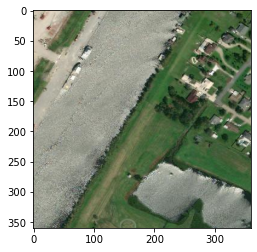

In [9]:
plt.imshow(np.array(Image.open(one_file_in_after)))

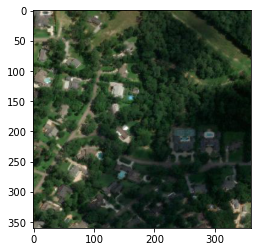

In [16]:
plt.imshow(np.array(Image.open(one_file_in_before)))

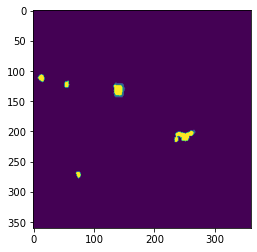

In [17]:
# What we've noticed is that due to a combination of just being trained on the vegas set and the decreased resolution, the building model fails to pick up a lot more buildings
plt.imshow(predict_footprint.predict(one_file_in_before)[0])

In [18]:
bad_polys:List[Polygon] = []
good_polys:List[Polygon] = []

if not after_masked.exists():
    after_masked.mkdir(parents=True)
file_count = 0
for file in before_dir.glob('*.tif'):
    file_count+=1
    
    img_original = np.array(Image.open(file))

    after_image_dir = before_dir / file.name
    geom = get_geomatrix_from_geotif(file)
    result = predict_footprint.predict(item=file)[0]
    pixel_ratio_to_original = result.shape[0]/img_original.shape[0]
    # the predicted footprints are a series of polygons that we'll need to cut of out the original image
    for index, poly in enumerate(mask_2_poly(result)):
        # Pull the respective file
        after_image_dir = after_dir / file.name.replace(before_filename,after_filename)
        after_img = cv2.imread(after_image_dir.__str__())
        after_img = cv2.resize(after_img,result.shape)
        mask_path = get_single_mask(poly,after_img,index,dest_dir=after_masked,image_name=file.stem)
        latlon_poly = pix_poly_to_latlon_pol(geom,poly,ratio=pixel_ratio_to_original)
        damage_value:Literal['damaged','undamaged'] = predict_damage.predict(mask_path)[0]
        if damage_value == 'damaged':
            bad_polys.append(latlon_poly)
        elif damage_value == 'undamaged':
            good_polys.append(latlon_poly)
        else:
            raise ValueError(f"I was not expecting this, labels from the buidling detection are stuffed, got {damage_value} expected one of undamaged or damaged")

with open("good.json",'w') as fp:
    json.dump(list_of_polys_to_geojson(good_polys),fp)
with open("bad.json",'w') as fp:
    json.dump(list_of_polys_to_geojson(bad_polys),fp)

In [1]:

import os

import cv2
import numpy as np
from tqdm import tqdm
from osgeo import gdal
from PIL import Image

from networks.dinknet import LinkNet34, DinkNet34
from networks.nllinknet_location import NL3_LinkNet, NL4_LinkNet, NL34_LinkNet, Baseline
from networks.nllinknet_pairwise_func import NL_LinkNet_DotProduct, NL_LinkNet_Gaussian, NL_LinkNet_EGaussian
from networks.unet import Unet
from util.test_framework import TTAFramework


In [13]:

from fastcore.basics import store_attr
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
import torch.nn.functional as F
%matplotlib inline
from skimage import measure
from shapely.geometry import shape, Point, Polygon, LineString
from pathlib import Path
import numpy as np
from typing import List, Tuple
from typing_extensions import Literal
import requests
from fastai.learner import load_learner
import cv2
import geopandas
from matplotlib import pyplot as plt
from osgeo import gdal
import json

import ssl
ssl._create_default_https_context = ssl._create_unverified_context #for remote development. not needed if on main server


In [2]:
aftertif = 'inference_data/after/10300100C540A500_-90.021_29.89.tif'
beforetif = 'inference_data/before/105001001E0A3300_-90.021_29.89.tif'
print(os.path.isfile(aftertif))
print(os.path.isfile(beforetif))

True
True


In [28]:
import argparse
import glob
import os

import cv2
import numpy as np
from tqdm import tqdm
from osgeo import gdal
from PIL import Image

from networks.dinknet import LinkNet34, DinkNet34
from networks.nllinknet_location import NL3_LinkNet, NL4_LinkNet, NL34_LinkNet, Baseline
from networks.nllinknet_pairwise_func import NL_LinkNet_DotProduct, NL_LinkNet_Gaussian, NL_LinkNet_EGaussian
from networks.unet import Unet
from util.test_framework import TTAFramework

import ssl
ssl._create_default_https_context = ssl._create_unverified_context #for remote development. not needed if on main server


In [29]:
def test_models_small(source):
    models = {'NL4_LinkNet': NL4_LinkNet, 'NL34_LinkNet': NL34_LinkNet,
              'Baseline': Baseline,
              'NL_LinkNet_DotProduct': NL_LinkNet_DotProduct, 'NL_LinkNet_Gaussian': NL_LinkNet_Gaussian,
              'NL_LinkNet_EGaussian': NL_LinkNet_EGaussian,
              'UNet': Unet, 'LinkNet': LinkNet34, 'DLinkNet': DinkNet34}

    model = models['NL34_LinkNet']
    n_class = 7
    name = "nia_cls_7_500"
    scales = (1.0,)

    if type(scales) == tuple:
        scales = list(scales)

    solver = TTAFramework(model, n_class) #Loads NL34_LinkNet from pytorch
    solver.load('weights/' + name + '.th') #Loads model weights - default nia_cls_7_500

    len_scales = int(len(scales))
    if len_scales > 1:
        print('multi-scaled test : ', scales)

    mask = solver.test_one_img_from_path(source, scales) #loads pytorch inference module, predicts each class, saves (1024,1024,7) array to mask
    mask = np.argmax(mask, axis=0) #argmax for each pixel, saves class index to (1024,1024) array to mask
    return mask


In [30]:
img = cv2.imread(aftertif)

In [31]:
res = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
cv2.imwrite('aftertest.png', res)

True

In [32]:
res = 'aftertest.png'

In [33]:
road_pred = test_models_small(res)

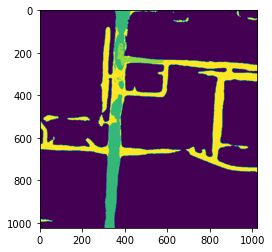

In [16]:
plt.imshow(road_pred)

In [74]:
road_pred.shape

(1024, 1024)

In [7]:
from fastai.learner import load_learner


In [ ]:
predict_footprint = load_learner(model_1_path)
predict_damage = load_learner(model_2_path)

bad_polys:List[Polygon] = []
good_polys:List[Polygon] = []

after_image_dir = aftertif
geom = get_geomatrix_from_geotif(beforetif)
result = predict_footprint.predict(item=beforetif)[0]
pixel_ratio_to_original = 1
# the predicted footprints are a series of polygons that we'll need to cut of out the original image
for index, poly in enumerate(mask_2_poly(result)):
    # Pull the respective file
    after_img = cv2.imread(after_image_dir)
    after_img = cv2.resize(after_img,result.shape)
    mask_path = get_single_mask(poly,after_img,index,dest_dir=Path().resolve(),image_name='help.png')
    
    latlon_poly = pix_poly_to_latlon_pol(geom,poly,ratio=pixel_ratio_to_original)
    damage_value:Literal['damaged','undamaged'] = predict_damage.predict(mask_path)[0]
    if damage_value == 'damaged':
        bad_polys.append(latlon_poly)
    elif damage_value == 'undamaged':
        good_polys.append(latlon_poly)
    else:
        raise ValueError(f"I was not expecting this, labels from the buidling detection are stuffed, got {damage_value} expected one of undamaged or damaged")
    

In [58]:
xy = np.asarray(bad_polys[0])

C:\Users\thomas\anaconda3\envs\irdis\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  """Entry point for launching an IPython kernel.


In [61]:
print(bad_polys[0])

POLYGON ((-90.02056153835713 29.88799521459226, -90.02060611475129 29.88801750278934, -90.02063950334457 29.88806203548116, -90.02055039425858 29.88810656817298, -90.02053920645768 29.88812890007241, -90.02055035055623 29.88814004417095, -90.02052806235915 29.88818462056512, -90.02055035055623 29.88826262925491, -90.02051691826061 29.88832949384616, -90.02055039425858 29.88835182574559, -90.02061725884982 29.88831839344996, -90.02067293564019 29.88835178204324, -90.02067293564019 29.88851894352137, -90.02066179154166 29.88859695221116, -90.02063950334457 29.88861924040824, -90.02067293564019 29.88875296959074, -90.02065069114545 29.88877521408548, -90.02056153835713 29.88876406998693, -90.020394376879 29.88879750228256, -90.02032751228775 29.88875292588839, -90.02028297959593 29.88869724909803, -90.02032755599009 29.88864152860532, -90.02032755599009 29.88859695221116, -90.02037208868191 29.88856356361788, -90.02042780917462 29.88855241951934, -90.02045014107405 29.88853008761991, -90.

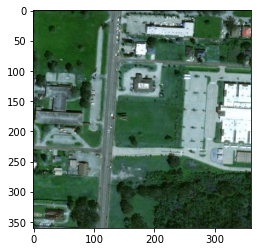

In [40]:
aftertif = 'inference_data/after/10300100C540A500_-90.021_29.89.tif'

x = cv2.imread(aftertif)
plt.imshow(x)

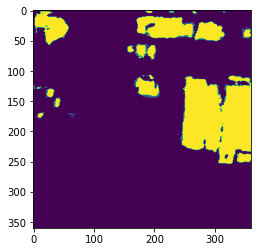

In [41]:
plt.imshow(predict_footprint.predict(aftertif)[0])